# Comparing Latency Measures with RIPE Atlas

This notebook compares latency measurements using ICMP, HTTP, UDP (high-ttl traceroute) and TCP (high-ttl traceroute) along common source/destination pairs to determine systematic latency bias and variance in the Atlas infrastructure.

In [1]:
# Some jupyter magic to set up the environment correctly
%load_ext autoreload
%autoreload 2
%matplotlib inline

# thanks for letting me know about your plans but i don't really care
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

# things we need, things to make us go
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections
import warnings
import hashlib
import requests
import os.path
import time
import json

Functions for caching and parsing MSMs

In [2]:
Alp = collections.namedtuple("Alp", ("time","af","proto","pid","sip","dip","rtt"))

RTT_NONE = 0.0
DATA_CACHE_PATH = 'data_cache'

def gen_dict(msm_ary):
    for a_res in msm_ary:
        yield a_res

def gen_alp(msm_ary):
    for a_res in msm_ary:
        if a_res['type'] == 'ping':
            if "rcvd" in a_res:
                for x in a_res["result"]:
                    rtt = None
                    try: 
                        rtt = float(x)
                    except:
                        try:
                            rtt = float(x['rtt'])
                        except:
                            pass
                    if rtt:
                        yield Alp(int(a_res['timestamp']), a_res['af'], a_res['proto'], 
                                  a_res['prb_id'], a_res['src_addr'], a_res['dst_addr'], rtt)
        
        elif a_res['type'] == 'traceroute':
            if ('result' in a_res) and ('result' in a_res['result'][-1]):
                for h_res in a_res['result'][-1]['result']:
                    if ('from' in h_res) and ('rtt' in h_res) and (h_res['from'] == a_res['dst_addr']):
                        yield Alp(int(a_res['timestamp']), a_res['af'], a_res['proto'] + '_TR', 
                                  a_res['prb_id'], a_res['src_addr'], a_res['dst_addr'], h_res['rtt'])

        # For HTTP, return each subresult as a separate RTT sample
        elif a_res['type'] == 'http':
            for r_res in a_res['result']:
                if ('res' in r_res) and (r_res['res'] < 400):
                    yield Alp(a_res['timestamp'], r_res['af'], 'HTTP', 
                              a_res['prb_id'], r_res['src_addr'], r_res['dst_addr'], r_res['rt'])                    

        

def get_msm(msm, gen=gen_dict, cachedir=None, start=None, stop=None):
    """
    Given an MSM, fetch it from the cache or from the RIPE Atlas API.
    Yield each separate result according to the generation function.
    """
    url = "https://atlas.ripe.net/api/v1/measurement/%u/result/" % (msm,)

    params = {"format": "json"}
    if start is not None and stop is not None:
        params["start"] = str(start)
        params["stop"] = str(stop)
    
    if cachedir and os.path.isdir(cachedir):
        filepath = os.path.join(cachedir, "measurement", "%u.json" % (msm,))

        # download if not present
        if not os.path.isfile(filepath):
            with open(filepath, mode="wb") as file:
                print("Cache miss, retrieving "+url)
                res = requests.get(url, params=params)

                if not res.ok:
                    raise "Atlas measurement API request failed: "+repr(res.json())
                
                file.write(res.content)

        # then read from cache
        with open(filepath) as stream:
            yield from gen(json.loads(stream.read()))

    else:
        # just read from the net
        res = requests.get(url, params=params)
        yield from gen(json.loads(res.content.decode("utf-8")))
        
def latency_dataframe(msms, start=None, stop=None, cachedir=None):
    """
    Given an iterable of MSMs, create a dataframe for doing latency measurements.
    """
    data = []
    
    # make a giant array
    for msm in msms:
        for alp in get_msm(msm, gen=gen_alp, 
                           start=start, stop=stop, 
                           cachedir=cachedir):
            data.append(alp)

    # create a dataframe from it
    return pd.DataFrame(data, columns=Alp._fields)


AtlasProbe = collections.namedtuple("AtlasProbe",
           ("pid", "version", "nat", "ip4", "ip6", "asn4", "asn6", "cc", "lat", "lon"))

def extract_atlas_probe(pobj):
    if "address_v4" in pobj:
        ip4 = pobj["address_v4"]
    else:
        ip4 = None

    if "address_v6" in pobj:
        ip6 = pobj["address_v6"]
    else:
        ip6 = None

    if "asn_v4" in pobj:
        asn4 = pobj["asn_v4"]
    else:
        asn4 = None

    if "asn_v6" in pobj:
        asn6 = pobj["asn_v6"]
    else:
        asn6 = None

    if "tags" in pobj:
        if "system-v1" in pobj["tags"]:
            version = 1
        elif "system-v2" in pobj["tags"]:
            version = 2
        elif "system-v3" in pobj["tags"]:
            version = 3
        elif "system-anchor" in pobj["tags"]:
            version = 4
        else:
            version = 0

        nat = "nat" in pobj["tags"]


    return AtlasProbe(pobj["id"], version, nat, ip4, ip6, asn4, asn6,
                      pobj["country_code"], pobj["latitude"], pobj["longitude"])

def get_probe(pid, cachedir=None):
    url = "https://atlas.ripe.net/api/v1/probe/%u" % (pid,)
    params = {"format": "json"}

    if cachedir and os.path.isdir(cachedir):
        filepath = os.path.join(cachedir, "probe", "%u.json" % (pid,))

        # try to read from cache
        try: 
            with open(filepath) as stream:
                return extract_atlas_probe(json.loads(stream.read()))
        except Exception as e:
            # download if not present
            if not os.path.isfile(filepath):
                with open(filepath, mode="wb") as file:
                    print("Cache miss, retrieving "+url)
                    res = requests.get(url, params=params)

                    if not res.ok:
                        raise "Atlas probe API request failed: "+repr(res.json())
                    
                    file.write(res.content)
                    return extract_atlas_probe(json.loads(res.content.decode("utf-8")))

    else:
        # just read from the net
        res = requests.get(url, params=params)
        return extract_atlas_probe(json.loads(res.content.decode("utf-8")))

def probe_dataframe_from_cache(pids):
    data = []
    
    # make a giant array
    for pid in pids:
        data.append(get_probe(pid, cachedir=DATA_CACHE_PATH))

    # create a dataframe from it
    df = pd.DataFrame(data, columns=AtlasProbe._fields)
    
    # indexed by probe ID
    df.index = df['pid']
    del(df['pid'])
    
    # and return it
    return df

def probe_dataframe_from_file(filename):
    data = []
    
    # make a giant array
    with open(filename) as stream:
        all_probes = json.loads(stream.read())
        for pobj in all_probes["objects"]:
            data.append(extract_atlas_probe(pobj))

    # create a dataframe from it
    df = pd.DataFrame(data, columns=AtlasProbe._fields)
    
    # indexed by probe ID
    df.index = df['pid']
    del(df['pid'])
    
    # and return it
    return df

Plotting utility functions

In [3]:
def plot_ecdf(a, **kwargs):
    sa = np.sort(a)
    yv = np.arange(len(sa))/float(len(sa))
    plt.plot(sa, yv, **kwargs)

You can configure the measurements in the variables below. `ANCHORS` is a map of anchor names to probe IDs; `ANCHORING_MSMS` is an array of anchoring measurement MSMs to these anchors. `PROBES` is the list of probe IDs used by the anchoring MSMs. These are computed in the [atlas_latency_creation](atlas_latency_creation.ipynb) notebook.

In [4]:
# Define anchors we care about
ANCHORS = {"nl-ams-as3333"  : 6001, "us-den-as7922"   : 6080, "uy-mvd-as28000"  : 6054,
           "us-dal-as7366"  : 6067, "uk-lon-as5459"   : 6091, "cz-brq-as197451" : 6110,
           "us-pao-as1280"  : 6045, "nl-ens-as1133"   : 6113, "ie-dub-as1213"   : 6050,
           "ru-mow-as47764" : 6046, "sg-sin-as133165" : 6077, "mv-mle-as7642"   : 6136,
           "kz-ala-as21299" : 6083, "fi-hel-as3292"   : 6036, "ua-iev-as29632"  : 6106,
           "br-sao-as22548" : 6099, "de-fra-as8763"   : 6060, "fr-cdg-as2486"   : 6004,
           "au-bne-as4608"  : 6055, "at-vie-as1120"   : 6042, "ca-van-as852"    : 6143,
           "hu-bud-as12303" : 6039, "ee-jvi-as198068" : 6111, "za-jnb-as10474"  : 6053,
           "is-rey-as1850"  : 6032, "de-str-as553"    : 6035, "mu-plu-as327681" : 6059,
           "ch-gtg-as20612" : 6115, "us-atl-as2914"   : 6066, "bg-sof-as197216" : 6112,
           "nz-hlz-as681"   : 6076, "pk-isb-as7590"   : 6128}

# MSM IDs from these anchors
MSM2_BY_ANCHOR = {
 'at-vie-as1120':   {'TCP/33435': 2444292, 'TCP/80': 2444291, 'UDP/33435': 2444293},
 'au-bne-as4608':   {'TCP/33435': 2444184, 'TCP/80': 2444183, 'UDP/33435': 2444185},
 'bg-sof-as197216': {'TCP/33435': 2444301, 'TCP/80': 2444300, 'UDP/33435': 2444302},
 'br-sao-as22548':  {'TCP/33435': 2444181, 'TCP/80': 2444180, 'UDP/33435': 2444182},
 'ca-van-as852':    {'TCP/33435': 2444280, 'TCP/80': 2444279, 'UDP/33435': 2444281},
 'ch-gtg-as20612':  {'TCP/33435': 2444295, 'TCP/80': 2444294, 'UDP/33435': 2444296},
 'cz-brq-as197451': {'TCP/33435': 2444214, 'TCP/80': 2444213, 'UDP/33435': 2444215},
 'de-fra-as8763':   {'TCP/33435': 2444175, 'TCP/80': 2444174, 'UDP/33435': 2444176},
 'de-str-as553':    {'TCP/33435': 2444314, 'TCP/80': 2444313, 'UDP/33435': 2444315},
 'ee-jvi-as198068': {'TCP/33435': 2444308, 'TCP/80': 2444307, 'UDP/33435': 2444309},
 'fi-hel-as3292':   {'TCP/33435': 2444193, 'TCP/80': 2444192, 'UDP/33435': 2444194},
 'fr-cdg-as2486':   {'TCP/33435': 2444178, 'TCP/80': 2444177, 'UDP/33435': 2444179},
 'hu-bud-as12303':  {'TCP/33435': 2444298, 'TCP/80': 2444297, 'UDP/33435': 2444299},
 'ie-dub-as1213':   {'TCP/33435': 2444211, 'TCP/80': 2444210, 'UDP/33435': 2444212},
 'is-rey-as1850':   {'TCP/33435': 2444289, 'TCP/80': 2444288, 'UDP/33435': 2444290},
 'kz-ala-as21299':  {'TCP/33435': 2444190, 'TCP/80': 2444189, 'UDP/33435': 2444191},
 'mu-plu-as327681': {'TCP/33435': 2444305, 'TCP/80': 2444303, 'UDP/33435': 2444306},
 'mv-mle-as7642':   {'TCP/33435': 2444202, 'TCP/80': 2444201, 'UDP/33435': 2444203},
 'nl-ams-as3333':   {'TCP/33435': 2444226, 'TCP/80': 2444225, 'UDP/33435': 2444227},
 'nl-ens-as1133':   {'TCP/33435': 2444208, 'TCP/80': 2444207, 'UDP/33435': 2444209},
 'nz-hlz-as681':    {'TCP/33435': 2444317, 'TCP/80': 2444316, 'UDP/33435': 2444318},
 'pk-isb-as7590':   {'TCP/33435': 2444286, 'TCP/80': 2444285, 'UDP/33435': 2444287},
 'ru-mow-as47764':  {'TCP/33435': 2444196, 'TCP/80': 2444195, 'UDP/33435': 2444197},
 'sg-sin-as133165': {'TCP/33435': 2444199, 'TCP/80': 2444198, 'UDP/33435': 2444200},
 'ua-iev-as29632':  {'TCP/33435': 2444187, 'TCP/80': 2444186, 'UDP/33435': 2444188},
 'uk-lon-as5459':   {'TCP/33435': 2444217, 'TCP/80': 2444216, 'UDP/33435': 2444218},
 'us-atl-as2914':   {'TCP/33435': 2444283, 'TCP/80': 2444282, 'UDP/33435': 2444284},
 'us-dal-as7366':   {'TCP/33435': 2444223, 'TCP/80': 2444222, 'UDP/33435': 2444224},
 'us-den-as7922':   {'TCP/33435': 2444229, 'TCP/80': 2444228, 'UDP/33435': 2444230},
 'us-pao-as1280':   {'TCP/33435': 2444205, 'TCP/80': 2444204, 'UDP/33435': 2444206},
 'uy-mvd-as28000':  {'TCP/33435': 2444220, 'TCP/80': 2444219, 'UDP/33435': 2444221},
 'za-jnb-as10474':  {'TCP/33435': 2444311, 'TCP/80': 2444310, 'UDP/33435': 2444312},
}

TCP_PORT = "33435"

# get a list of MSMs
TRACECONN_MSMS = []
for anchor in MSM2_BY_ANCHOR:
    for proto in ('TCP/'+TCP_PORT, 'UDP/33435'):
        TRACECONN_MSMS.append(MSM2_BY_ANCHOR[anchor][proto])

### Data load

This bit of code grabs data from RIPE Atlas and caches it in the `data_cache` directory. For this code to work, you'll need to:

- create a `data_cache/measurements` directory
- get the Atlas probe archive from [ftp.ripe.net](ftp://ftp.ripe.net/ripe/atlas/probes/archive/meta-latest) and place it in the `data_cache` directory

The `latency_dataframe` call will automatically retrieve Atlas measurements using the API and place them in `data_cache`; the first run of this script will take a while to do the full data retrieval (the measurements take 231MB of space).

In [5]:
# Create a unified dataframe containing all the latency measurements we have
ldf = latency_dataframe(TRACECONN_MSMS, cachedir=DATA_CACHE_PATH)

# add n column for counting and indexing
ldf['n'] = 1

# Get a dataframe with metadata for the probes these measurements use
pdf = probe_dataframe_from_file("data_cache/all-probes.json")

# Make lookup tables for anchors via v4 and v6 address
adf = pdf.loc[6001:6156]

anchor_by_ip4 = pd.DataFrame(data = adf.loc[:,["ip4"]]).dropna()
anchor_by_ip4["aid"] = anchor_by_ip4.index
anchor_by_ip4.index = anchor_by_ip4["ip4"]
del anchor_by_ip4["ip4"] 

anchor_by_ip6 = pd.DataFrame(data = adf.loc[:,["ip6"]]).dropna()
anchor_by_ip6["aid"] = anchor_by_ip6.index
anchor_by_ip6.index = anchor_by_ip6["ip6"]
del anchor_by_ip6["ip6"] 

anchor_by_ip = pd.concat([anchor_by_ip4, anchor_by_ip6])

# Add anchor ID to each latency datapoint
ldf = pd.merge(ldf, anchor_by_ip, left_on="dip", right_index=True)

In [6]:
# Now assign anchor and probe sequence numbers by longitude
pids = ldf['pid'].unique()
aids = ldf['aid'].unique()

pseq_lut = pd.DataFrame(data = {'pseq': np.arange(len(pids))},
                        index = pdf.loc[pids].sort('lon').index)
aseq_lut = pd.DataFrame(data = {'aseq': np.arange(len(aids))},
                        index = pdf.loc[aids].sort('lon').index)

ldf = pd.merge(ldf, pseq_lut, left_on="pid", right_index=True)
ldf = pd.merge(ldf, aseq_lut, left_on="aid", right_index=True)

In [7]:
npmedian = lambda q: np.percentile(q, 50)

# Now group by path for each protocol (v4 only for now)
lpdf = {4: {}}
lpg_seq = {4: {}}
lpg_id = {4: {}}

for af in (4,):
    for proto in ('UDP_TR', 'TCP_TR'):
        lpdf[af][proto] = ldf[(ldf['proto'] == proto) & (ldf['af'] == af)]
        lg_seq = lpdf[af][proto].groupby(('aseq','pseq'))
        lpg_seq[af][proto] = pd.DataFrame(lg_seq.sum()['n'])
        lpg_seq[af][proto].columns = [proto+"_n"]
        lpg_seq[af][proto][proto+'_min_rtt'] = lg_seq['rtt'].min()
        lpg_seq[af][proto][proto+'_std_rtt'] = lg_seq['rtt'].std()
        lpg_seq[af][proto][proto+'_mean_rtt'] = lg_seq['rtt'].mean()
        lpg_seq[af][proto][proto+'_med_rtt'] = lg_seq['rtt'].aggregate(npmedian)
        lg_id = lpdf[af][proto].groupby(('aid','pid'))
        lpg_id[af][proto] = pd.DataFrame(lg_id.sum()['n'])
        lpg_id[af][proto].columns = [proto+"_n"]
        lpg_id[af][proto][proto+'_min_rtt'] = lg_id['rtt'].min()
        lpg_id[af][proto][proto+'_std_rtt'] = lg_id['rtt'].std()
        lpg_id[af][proto][proto+'_mean_rtt'] = lg_id['rtt'].mean()
        lpg_id[af][proto][proto+'_med_rtt'] = lg_id['rtt'].aggregate(npmedian)

        
# now make a union dataframe for comparing UDP and TCP for v4 connectivity
lpig4_oseq = pd.merge(lpg_seq[4]['UDP_TR'], lpg_seq[4]['TCP_TR'], 
                     left_index=True, right_index=True, how="outer")

# and an intersection dataframe for comparing UDP and TCP for v4 connectivity
lpig4_iseq = pd.merge(lpg_seq[4]['UDP_TR'], lpg_seq[4]['TCP_TR'], 
                     left_index=True, right_index=True, how="inner")

# now an intersection by ID for distance measurements
lpig4_iid = pd.merge(lpg_id[4]['UDP_TR'], lpg_id[4]['TCP_TR'], 
                     left_index=True, right_index=True, how="inner")

# Fill missing data in the grid with zeroes
mia = [ [],[] ]
for aseq in range(0, max(ldf['aseq'])):
    for pseq in range(0, max(ldf['pseq'])):
        mia[0].append(aseq)
        mia[1].append(pseq)

mi = pd.MultiIndex.from_tuples(list(zip(*mia)), names=["aseq","pseq"])
lpig4_oseq = lpig4_oseq.reindex(mi).fillna(0)
lpig4_iseq = lpig4_iseq.reindex(mi).fillna(0)

In [8]:
# add columns for connectivity bias
lpig4_oseq['max_n'] = lpig4_oseq[["UDP_TR_n","TCP_TR_n"]].max(axis=1)
lpig4_oseq['UDP_conn_bias'] = (lpig4_oseq["UDP_TR_n"] - lpig4_oseq["TCP_TR_n"]) /  (lpig4_oseq["UDP_TR_n"] + lpig4_oseq["TCP_TR_n"]) 

In [9]:
# calculate some things for the latency section of the paper

print ("between %u Atlas probes and %u Atlas anchors" % (len(ldf["pid"].unique()), len(ldf["aid"].unique())))
print ("probes in %u networks in %u countries" % (len(pdf.loc[ldf["pid"].unique()]['asn4'].unique()),
                                                  len(pdf.loc[ldf["pid"].unique()]['cc'].unique())))
print ("anchors in %u networks in %u countries" % (len(pdf.loc[ldf["aid"].unique()]['asn4'].unique()),
                                                  len(pdf.loc[ldf["aid"].unique()]['cc'].unique())))

between 115 Atlas probes and 32 Atlas anchors
probes in 110 networks in 44 countries
anchors in 32 networks in 27 countries


### Plots (for understanding the dataset and for the paper)

First, plot the total number of observations by probe and anchor. Greys here indicate probes/anchors that were partially offline, or that have fewer TCP than UDP observations, or vice-versa.

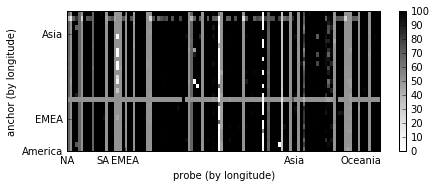

In [10]:
plt.figure(figsize=(7,2.5))
plt.pcolor((lpig4_oseq["UDP_TR_n"] + lpig4_oseq["TCP_TR_n"]).unstack(), 
           cmap="Greys", vmin=0, vmax=100)
plt.colorbar()
plt.xlim(0,max(ldf['pseq']))
plt.ylim(0,max(ldf['aseq']))
plt.xticks((0,13,21,83,107),("NA", "SA", "EMEA", "Asia", "Oceania")) 
plt.yticks((0,7,26),("America", "EMEA", "Asia")) 
plt.xlabel("probe (by longitude)")
plt.ylabel("anchor (by longitude)")

Plot UDP connectivity bias: subtract TCP sample count from UDP sample count, normalized to [-1,1].

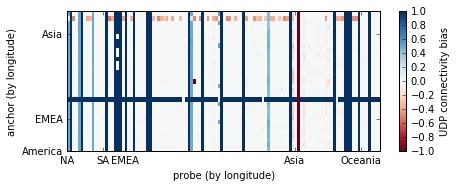

In [11]:
plt.figure(figsize=(7,2.5))
plt.pcolor((lpig4_oseq["UDP_conn_bias"]).unstack().fillna(0), 
           cmap="RdBu")
plt.colorbar(label="UDP connectivity bias")
plt.xlim(0,max(ldf['pseq']))
plt.ylim(0,max(ldf['aseq']))
plt.xticks((0,13,21,83,107),("NA", "SA", "EMEA", "Asia", "Oceania")) 
plt.yticks((0,7,26),("America", "EMEA", "Asia")) 
plt.xlabel("probe (by longitude)")
plt.ylabel("anchor (by longitude)")
#plt.savefig("plots/conngrid_"+TCP_PORT+".pdf", bbox_inches="tight")

In [12]:
# Classify probe connectivity problems
probe_group = lpig4_oseq.groupby(level=1)
probe_tcp_conn = probe_group["TCP_TR_n"].sum()
probe_udp_conn = probe_group["UDP_TR_n"].sum()
probe_udp_conn_bias = (probe_udp_conn - probe_tcp_conn) / (probe_udp_conn + probe_tcp_conn)

probes_udp_blocked = probe_udp_conn_bias[(probe_tcp_conn > 100) & (probe_udp_conn == 0)]
probes_tcp_blocked = probe_udp_conn_bias[(probe_udp_conn > 100) & (probe_tcp_conn == 0)]
probes_not_blocked = probe_udp_conn_bias.loc[probe_udp_conn_bias.index.difference(probes_udp_blocked.index.union(probes_tcp_blocked.index))]
probes_no_bias = probes_not_blocked[abs(probes_not_blocked) < 0.02]
probes_kinda_broken = probes_not_blocked.loc[probes_not_blocked.index.difference(probes_no_bias.index)]

print ("%2u probes (%5.2f%%) in case (i)" % (len(probes_no_bias), 100*len(probes_no_bias)/len(probe_group)))
print ("%2u probes (%5.2f%%) in case (ii)" % (len(probes_udp_blocked), 100*len(probes_udp_blocked)/len(probe_group)))
print ("%2u probes (%5.2f%%) in case (iii)" % (len(probes_tcp_blocked), 100*len(probes_tcp_blocked)/len(probe_group)))
print ("%2u probes (%5.2f%%) in case (iv)" % (len(probes_kinda_broken), 100*len(probes_kinda_broken)/len(probe_group)))

82 probes (71.93%) in case (i)
 1 probes ( 0.88%) in case (ii)
21 probes (18.42%) in case (iii)
10 probes ( 8.77%) in case (iv)


Plot difference in mean RTTs between TCP and UDP. This one didn't make it into the paper; we use median instead.

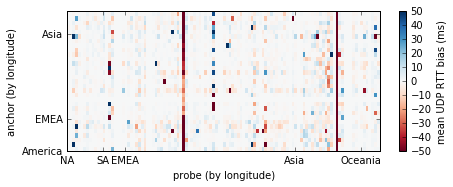

In [13]:
plt.figure(figsize=(7,2.5))
plt.pcolor((lpig4_iseq["TCP_TR_mean_rtt"] - lpig4_iseq["UDP_TR_mean_rtt"]).unstack().fillna(0), 
           cmap="RdBu", vmin=-50, vmax=50)
plt.colorbar(label="mean UDP RTT bias (ms)")
plt.xlim(0,max(ldf['pseq']))
plt.ylim(0,max(ldf['aseq']))
plt.xticks((0,13,21,83,107),("NA", "SA", "EMEA", "Asia", "Oceania")) 
plt.yticks((0,7,26),("America", "EMEA", "Asia")) 
plt.xlabel("probe (by longitude)")
plt.ylabel("anchor (by longitude)")

Plot difference in median RTTs by probe/anchor pair between TCP and UDP.

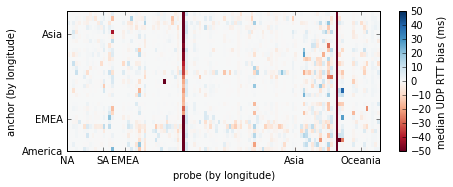

In [14]:
plt.figure(figsize=(7,2.5))
plt.pcolor((lpig4_iseq["TCP_TR_med_rtt"] - lpig4_iseq["UDP_TR_med_rtt"]).unstack().fillna(0), 
           cmap="RdBu", vmin=-50, vmax=50)
plt.colorbar(label="median UDP RTT bias (ms)")
plt.xlim(0,max(ldf['pseq']))
plt.ylim(0,max(ldf['aseq']))
plt.xticks((0,13,21,83,107),("NA", "SA", "EMEA", "Asia", "Oceania")) 
plt.yticks((0,7,26),("America", "EMEA", "Asia")) 
plt.xlabel("probe (by longitude)")
plt.ylabel("anchor (by longitude)")
plt.savefig("plots/atlas_medrtt_"+TCP_PORT+".pdf", bbox_inches="tight")

Plot difference in minimum RTTs by probe/anchor pair between TCP and UDP.

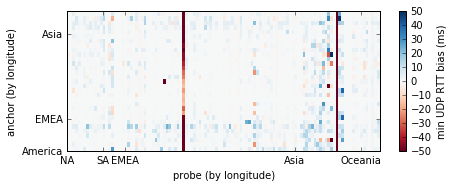

In [15]:
plt.figure(figsize=(7,2.5))
plt.pcolor((lpig4_iseq["TCP_TR_min_rtt"] - lpig4_iseq["UDP_TR_min_rtt"]).unstack().fillna(0), 
           cmap="RdBu", vmin=-50, vmax=50)
plt.colorbar(label="min UDP RTT bias (ms)")
plt.xlim(0,max(ldf['pseq']))
plt.ylim(0,max(ldf['aseq']))
plt.xticks((0,13,21,83,107),("NA", "SA", "EMEA", "Asia", "Oceania")) 
plt.yticks((0,7,26),("America", "EMEA", "Asia")) 
plt.xlabel("probe (by longitude)")
plt.ylabel("anchor (by longitude)")
#plt.savefig("plots/minrtt_"+TCP_PORT+".pdf", bbox_inches="tight")

compare all-samples bias between Copycat and Atlas 

**NOTE** for this analysis, you'll first need to unzip `data_cache/copycat-rtt-samples.csv.bz2`

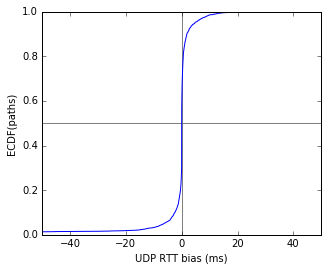

In [16]:
# all copycat samples
#rtt_copycat_df = pd.read_csv("data_cache/copycat-rtt-samples.csv").loc[:,["udpRtt","tcpRtt"]]

plt.figure(figsize=(5,4))
plt.plot((0,0),(0,1), color="grey")
plt.plot((-50,50),(0.5,0.5), color="grey")
plot_ecdf((lpig4_iseq["TCP_TR_med_rtt"] - lpig4_iseq["UDP_TR_med_rtt"]).dropna())
#plot_ecdf(rtt_copycat_df["tcpRtt"] - rtt_copycat_df["udpRtt"])
plt.xlim(-50,50)
plt.xlabel("UDP RTT bias (ms)")
plt.ylabel("ECDF(paths)")

# plt.text(-12,0.7,"Copycat")
# plt.text(2,0.4,"Atlas")

plt.savefig("plots/atlas_medrtt_ecdf.pdf", bbox_inches="tight")

In [18]:
(lpig4_iseq["TCP_TR_med_rtt"] - lpig4_iseq["UDP_TR_med_rtt"]).dropna().to_csv("plots/atlas_medrtt.csv")

In [32]:
medians_df = lpig4_iseq.loc[:,["TCP_TR_med_rtt","UDP_TR_med_rtt"]]
medians_df[(medians_df.T != 0).any()].to_csv("plots/atlas_medians_per_path_proto.csv")

In [22]:
((lpig4_iseq["TCP_TR_med_rtt"] - lpig4_iseq["UDP_TR_med_rtt"]).dropna()).describe()

count    3534.000000
mean       -3.674020
std        33.851077
min      -519.152500
25%        -0.165000
50%         0.000000
75%         0.352000
max        39.495000
dtype: float64

In [23]:
median_rtt_bias = lpig4_iseq["TCP_TR_med_rtt"] - lpig4_iseq["UDP_TR_med_rtt"]
print("The median path has a %u ms bias between UDP and TCP round trip times; the \\nth{5} percentile %5.2f ms" %
      (np.percentile(median_rtt_bias, 50), np.percentile(median_rtt_bias, 5)))

The median path has a 0 ms bias between UDP and TCP round trip times; the \nth{5} percentile -6.34 ms


### Distance-correlation code

Assign (simplified) distance to each probe/anchor pair based on the Atlas probe metadata, and compare latency to this distance.

In [18]:
# Define a lat-lon / distance function
import math

EARTH_RADIUS_KM = 6373

def on_unit_sphere(lat1, long1, lat2, long2):
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
 
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc

# Now make a union of all indices
apindex = lpg_id[4]['UDP_TR'].index.union(lpg_id[4]['TCP_TR'])
 
# Make a probe location lookup from the probe dataframe
probe_loc = pdf.loc[pd.Index(apindex.levels[1].unique()),['lat','lon']]
probe_loc.columns = ('plat','plon')

# Make an anchor location lookup from the anchor dataframe
anchor_loc = pdf.loc[pd.Index(apindex.levels[0].unique()),['lat','lon']]
anchor_loc.columns = ('alat','alon')

# Make a probe/anchor location dataframe on the union index
distlu = pd.DataFrame(np.arange(len(apindex)), index=apindex)
distlu.reset_index(inplace=True)
del(distlu[0])

distlu = pd.merge(distlu, probe_loc, left_on='pid', right_index=True)
distlu = pd.merge(distlu, anchor_loc, left_on='aid', right_index=True)

# filter some garbage (??)
distlu = distlu[distlu['aid'] != "T"]

distlu['km'] = distlu.apply(lambda x: on_unit_sphere(x["alat"], x["alon"], 
                                x["plat"], x["plon"]), axis=1) * EARTH_RADIUS_KM
distlu.index = pd.MultiIndex.from_tuples(list(zip(distlu['aid'].values, distlu['pid'].values)), names=('aid','pid'))


In [19]:
lpig4_iid = pd.merge(lpig4_iid, distlu, left_index=True, right_index=True, how="inner")

For fun: look for probe/anchor pairs that might have minimum TCP RTTs faster than light. 

In [20]:
C_KM_MS = 299.792458
C_FIBER_MULTIPLE = 0.41

lpig4_iid["ftl_ms"] = lpig4_iid["km"] / (C_KM_MS * C_FIBER_MULTIPLE)
lpig4_iid[lpig4_iid["TCP_TR_min_rtt"] < lpig4_iid["ftl_ms"]]

,,UDP_TR_n,UDP_TR_min_rtt,UDP_TR_std_rtt,UDP_TR_mean_rtt,UDP_TR_med_rtt,TCP_TR_n,TCP_TR_min_rtt,TCP_TR_std_rtt,TCP_TR_mean_rtt,TCP_TR_med_rtt,aid,pid,plat,plon,alat,alon,km,ftl_ms
aid,pid,,,,,,,,,,,,,,,,,,
6001,917,51,18.502,22.615828,24.216686,18.845,51,1.630,10.174833,3.220667,1.6720,6001,917,50.5505,3.0275,52.3675,4.8875,239.696145,1.950098
6032,917,51,50.092,0.356706,50.666235,50.673,51,1.633,3.087221,2.186843,1.6620,6032,917,50.5505,3.0275,64.1385,-21.9015,2100.232088,17.086878
6035,917,51,19.945,0.685712,20.447059,20.298,51,1.630,0.441283,1.838275,1.6540,6035,917,50.5505,3.0275,48.7395,9.0985,481.231557,3.915160
6036,917,51,46.295,2.483900,47.485314,47.081,51,1.632,0.166584,1.764039,1.6560,6036,917,50.5505,3.0275,60.1705,24.9385,1736.500600,14.127665
6039,917,51,36.273,9.375727,38.086451,36.530,51,1.631,0.280448,1.762392,1.6630,6039,917,50.5505,3.0275,47.5015,19.0385,1213.270571,9.870817
6042,917,51,27.247,1.778472,27.961961,27.572,51,1.632,0.152183,1.767765,1.7120,6042,917,50.5505,3.0275,48.2085,16.3695,999.126217,8.128601
6045,917,51,155.092,24.865359,162.036745,155.494,51,1.635,10.039421,3.933608,1.6730,6045,917,50.5505,3.0275,37.4395,-122.1405,8864.723663,72.120818
6046,917,51,61.576,20.648047,68.708314,62.152,51,1.638,2.792718,2.207706,1.6940,6046,917,50.5505,3.0275,55.7605,37.6195,2352.023769,19.135382
6050,917,51,22.204,0.500327,22.564353,22.481,51,1.633,11.001757,3.267647,1.6760,6050,917,50.5505,3.0275,53.3275,-6.3705,713.912246,5.808183
